In [1]:
import os
from collections import defaultdict
import openreview

import matplotlib.pyplot as plt
import numpy as np
from expertise.models import model_utils



In [2]:
# interact with OpenReview API to get data using the UAI 2018 Admin credentials
client = openreview.Client(username='uai2018admin',password='ycn2018')

reviews = list(openreview.tools.iterget_notes(client, 
                                              invitation='auai.org/UAI/2018/-/Paper.*/Official_Review',
                                              details='forumContent'))

subject_area_notes = client.get_notes(invitation='auai.org/UAI/2018/-/Registration/Subject/Areas')
subjects_by_user = {n.signatures[0]: n.content['subject_areas'] for n in subject_area_notes}

anon_groups = list(openreview.tools.iterget(client.get_groups, id='auai.org/UAI/2018/Paper.*/AnonReviewer.*'))
signature_by_anonid = {}
for group in anon_groups:
    if group.members:
        signature_by_anonid[group.id] = group.members[0]

## Correlation of basic statistics with model scores
Generate a scatter plot of each model's normalized scores with the following variables:
- subject area overlap score (use recall and F1)
- reviewer confidence
- review length

In [3]:
data_dir = '../data/uai18/'

submission_records_dir = os.path.join(data_dir, 'submission_records_fulltext')
reviewer_archives_dir = os.path.join(data_dir, 'reviewer_archives')
reviewer_bids_file = os.path.join(data_dir, 'reviewer_bids.jsonl')
tfidf_scores_file = os.path.join(data_dir, 'tfidf-score-matrix.txt')
tpms_scores_file = os.path.join(data_dir,'tpms-score-matrix.txt')
random_scores_file = os.path.join(data_dir, 'random-score-matrix.txt')

tpms_score_matrix = model_utils.read_scores(tpms_scores_file)
tfidf_score_matrix = model_utils.read_scores(tfidf_scores_file)
random_score_matrix = model_utils.read_scores(random_scores_file)

In [4]:
tpms_array = np.array([[tpms_score_matrix[note_id][reviewer_id] for reviewer_id in tpms_score_matrix[note_id]] for note_id in tpms_score_matrix])
tpms_max_val = tpms_array.max()
tpms_min_val = tpms_array.min()

tfidf_array = np.array([[tfidf_score_matrix[note_id][reviewer_id] for reviewer_id in tfidf_score_matrix[note_id]] for note_id in tfidf_score_matrix])
tfidf_max_val = tfidf_array.max()
tfidf_min_val = tfidf_array.min()

random_array = np.array([[random_score_matrix[note_id][reviewer_id] for reviewer_id in random_score_matrix[note_id]] for note_id in random_score_matrix])
random_max_val = random_array.max()
random_min_val = random_array.min()

In [5]:
def get_subj_overlap(paper_subjects, reviewer_subjects):
    '''
    What percentage of the paper subjects does the reviewer subjects include?
    '''
    paper_set = set(paper_subjects)
    reviewer_set = set(reviewer_subjects)
    return len(paper_set.intersection(reviewer_set))/len(paper_set)

In [6]:
def get_subj_recall(paper_subjects, reviewer_subjects):
    '''
    What percentage of the paper subjects does the reviewer subjects include?
    '''
    paper_set = set(paper_subjects)
    reviewer_set = set(reviewer_subjects)
    true_positives = paper_set.intersection(reviewer_set)
    return len(true_positives)/len(paper_set)

In [7]:
def get_subj_precision(paper_subjects, reviewer_subjects):
    paper_set = set(paper_subjects)
    reviewer_set = set(reviewer_subjects)
    true_positives = paper_set.intersection(reviewer_set)
    return len(true_positives)/len(reviewer_set)

In [8]:
def get_subj_f1(paper_subjects, reviewer_subjects):
    # TODO
    recall = get_subj_recall(paper_subjects, reviewer_subjects)
    precision = get_subj_precision(paper_subjects, reviewer_subjects)
    if precision+recall > 0.0:
        return 2*precision*recall/(precision+recall)
    else:
        return 0.0

In [9]:
def normalize_array(scores):
    filtered_scores = [s for s in scores if s !=float('-inf')]
    max_val = max(filtered_scores)
    min_val = min(filtered_scores)
    
    return [(s-min_val)/(max_val-min_val) for s in filtered_scores]

In [10]:
normalize_array([10.0,20.0,30.0, float('-inf')])

[0.0, 0.5, 1.0]

Text(0,0.5,'TFIDF')

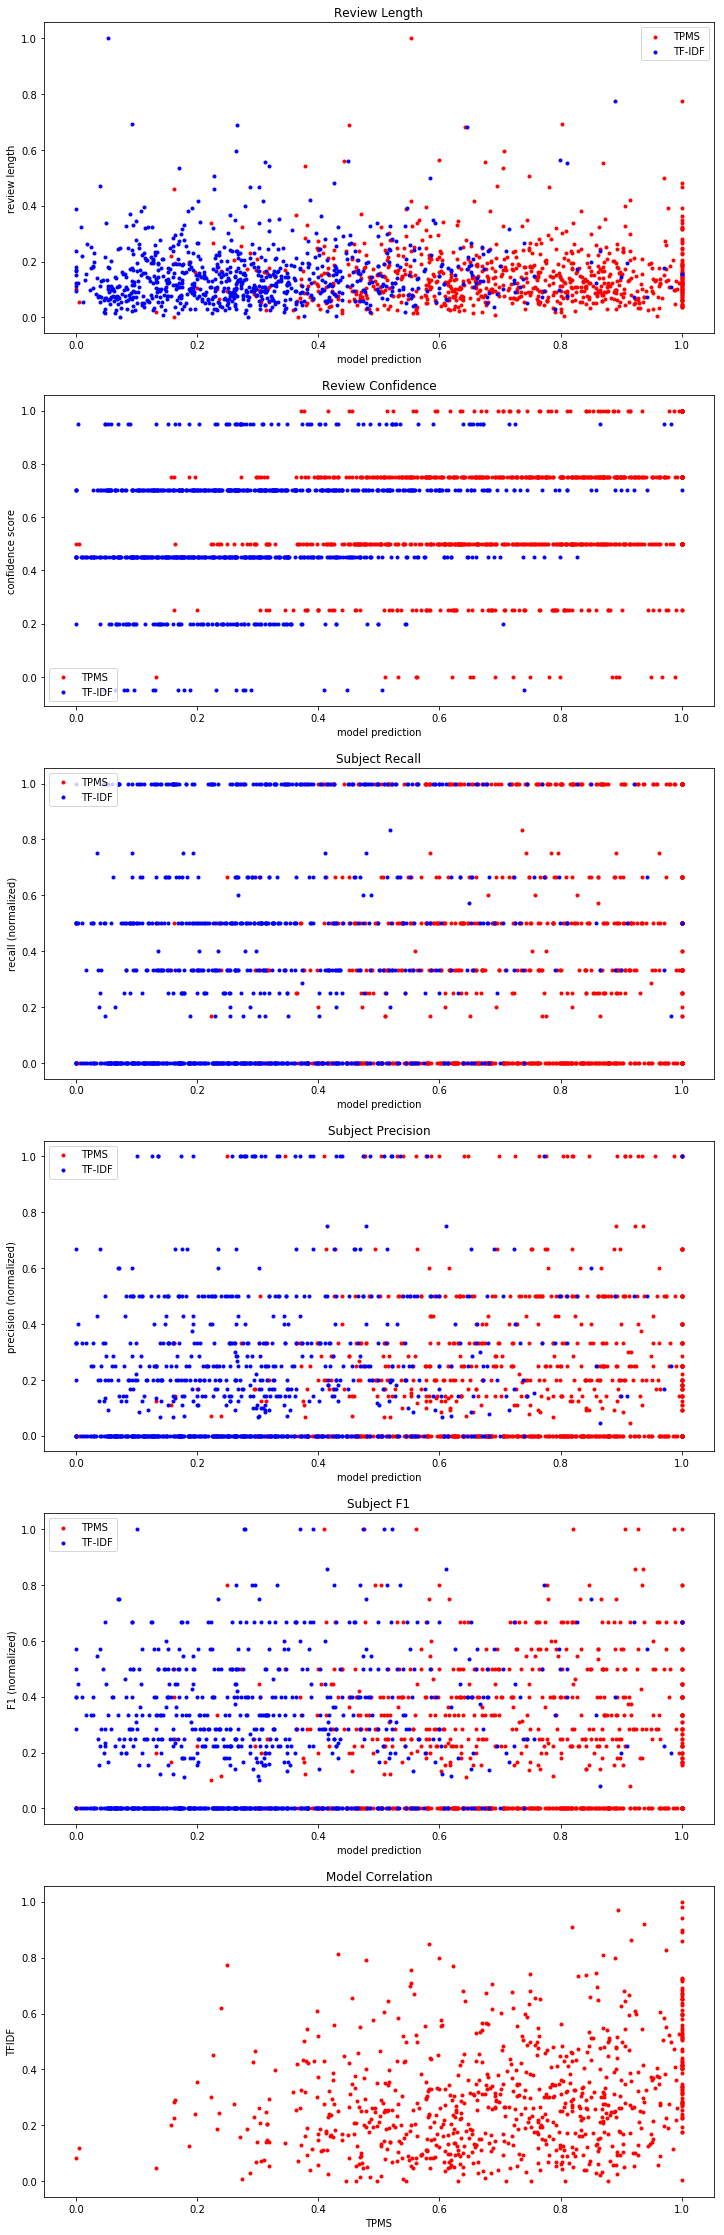

In [11]:
'''
Notes on normalization for review lengths and confidence scores:

TPMS scores are positively correlated with the existence of a review
(because we used TPMS scores to assign papers to reviewers).

'''

tpms_scores = []
tfidf_scores = []
random_scores = []
review_lengths = []
confidence_scores = []
subject_recall = []
subject_precision = []
subject_f1 = []

for review in reviews:
    user_id = signature_by_anonid[review.signatures[0]]

    # ugly way to make sure that we only get evaluation data where a fair comparison can be made
    if all([
        review.forum in tpms_score_matrix,
        user_id in tpms_score_matrix.get(review.forum, {}),
        review.forum in tfidf_score_matrix,
        user_id in tfidf_score_matrix.get(review.forum, {}),
        review.forum in random_score_matrix,
        user_id in random_score_matrix.get(review.forum, {}),
        tpms_score_matrix.get(review.forum, {}).get(user_id, float('-inf')) >= 0.0,
        tfidf_score_matrix.get(review.forum, {}).get(user_id, float('-inf')) >= 0.0,
        random_score_matrix.get(review.forum, {}).get(user_id, float('-inf')) >= 0.0,
        user_id in subjects_by_user
    ]):
        tpms_scores.append(tpms_score_matrix[review.forum][user_id])
        tfidf_scores.append(tfidf_score_matrix[review.forum][user_id])
        random_scores.append(random_score_matrix[review.forum][user_id])
    
        review_lengths.append(len(review.content['review']))
        confidence_scores.append(float(review.content['confidence'][0]))
        
        paper_subjects = review.details['forumContent']['subject areas']
        reviewer_subjects = subjects_by_user[user_id]
        subject_recall.append(get_subj_recall(paper_subjects, reviewer_subjects))
        subject_precision.append(get_subj_precision(paper_subjects, reviewer_subjects))
        subject_f1.append(get_subj_f1(paper_subjects, reviewer_subjects))

normalized_tpms_scores = normalize_array(tpms_scores)
normalized_tfidf_scores = normalize_array(tfidf_scores)

normalized_subject_recall = normalize_array(subject_recall)
normalized_subject_precision = normalize_array(subject_precision)
normalized_subject_f1 = normalize_array(subject_f1)
normalized_review_length = normalize_array(review_lengths)
normalized_confidence_scores = normalize_array(confidence_scores)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(12, 40), nrows=6)

# plot vs review lengths
ax1.scatter(x=normalized_tpms_scores, y=normalized_review_length, marker='.', c='r')
ax1.scatter(x=normalized_tfidf_scores, y=normalized_review_length, marker='.',c='b')

ax1.set_title('Review Length')
ax1.set_xlabel('model prediction')
ax1.set_ylabel('review length')
ax1.legend(['TPMS', 'TF-IDF'])

# plot vs. confidence scores
ax2.scatter(x=normalized_tpms_scores, y=normalized_confidence_scores, marker='.', c='r')
ax2.scatter(x=normalized_tfidf_scores, y=[c-0.05 for c in normalized_confidence_scores], marker='.', c='b')
ax2.set_title('Review Confidence')
ax2.set_xlabel('model prediction')
ax2.set_ylabel('confidence score')
ax2.legend(['TPMS', 'TF-IDF'])

# plot vs. subject area recall score
ax3.scatter(x=normalized_tpms_scores, y=normalized_subject_recall, marker='.', c='r')
ax3.scatter(x=normalized_tfidf_scores, y=normalized_subject_recall, marker='.', c='b')
ax3.set_title('Subject Recall')
ax3.set_xlabel('model prediction')
ax3.set_ylabel('recall (normalized)')
ax3.legend(['TPMS', 'TF-IDF'])

# plot vs. subject area precision score
ax4.scatter(x=normalized_tpms_scores, y=normalized_subject_precision, marker='.', c='r')
ax4.scatter(x=normalized_tfidf_scores, y=normalized_subject_precision, marker='.', c='b')
ax4.set_title('Subject Precision')
ax4.set_xlabel('model prediction')
ax4.set_ylabel('precision (normalized)')
ax4.legend(['TPMS', 'TF-IDF'])

# plot vs. subject area F1 score
ax5.scatter(x=normalized_tpms_scores, y=normalized_subject_f1, marker='.', c='r')
ax5.scatter(x=normalized_tfidf_scores, y=normalized_subject_f1, marker='.', c='b')
ax5.set_title('Subject F1')
ax5.set_xlabel('model prediction')
ax5.set_ylabel('F1 (normalized)')
ax5.legend(['TPMS', 'TF-IDF'])
# plot against each other
ax6.scatter(x=normalized_tpms_scores, y=normalized_tfidf_scores, marker='.', c='r')

ax6.set_title('Model Correlation')
ax6.set_xlabel('TPMS')
ax6.set_ylabel('TFIDF')
